In [11]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

In [12]:
df = pd.read_csv("fake_job_postings.csv")

In [13]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [14]:
df.shape

(17880, 18)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [16]:
df.nunique()

job_id                 17880
title                  11231
location                3105
department              1337
salary_range             874
company_profile         1709
description            14801
requirements           11967
benefits                6204
telecommuting              2
has_company_logo           2
has_questions              2
employment_type            5
required_experience        7
required_education        13
industry                 131
function                  37
fraudulent                 2
dtype: int64

In [17]:
df['fraudulent'].value_counts()

fraudulent
0    17014
1      866
Name: count, dtype: int64

In [18]:
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [19]:
df['location'].fillna('Unknown', inplace=True)
df['department'].fillna('Unknown', inplace=True)
df['salary_range'].fillna('Not Specified', inplace=True)
df['employment_type'].fillna('Not Specified', inplace=True)
df['required_experience'].fillna('Not Specified', inplace=True)
df['required_education'].fillna('Not Specified', inplace=True)
df['industry'].fillna('Not Specified', inplace=True)
df['function'].fillna('Not Specified', inplace=True)

C:\Users\afand\AppData\Local\Temp\ipykernel_5820\1166088697.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['location'].fillna('Unknown', inplace=True)
C:\Users\afand\AppData\Local\Temp\ipykernel_5820\1166088697.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example

In [20]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,Not Specified,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,Not Specified,Not Specified,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,Not Specified,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,Not Specified,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",Unknown,Not Specified,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,Not Specified,Not Specified,Not Specified,Not Specified,Not Specified,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,Not Specified,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",Unknown,Not Specified,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [21]:
df['combined_text'] = df[['title', 'location', 'salary_range', 'company_profile', 'description', 
                          'requirements', 'benefits', 'employment_type', 
                          'required_experience', 'required_education', 'industry', 
                          'function', 'department']].apply(
    lambda x: ' '.join(x.fillna('').astype(str)), axis=1
)

In [22]:
df.isnull().sum()

job_id                    0
title                     0
location                  0
department                0
salary_range              0
company_profile        3308
description               1
requirements           2696
benefits               7212
telecommuting             0
has_company_logo          0
has_questions             0
employment_type           0
required_experience       0
required_education        0
industry                  0
function                  0
fraudulent                0
combined_text             0
dtype: int64

In [23]:
text_columns = ['title', 'company_profile', 'description', 'requirements', 'benefits']
df[text_columns] = df[text_columns].fillna('Missing')

In [24]:
df.isna().sum()

job_id                 0
title                  0
location               0
department             0
salary_range           0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
combined_text          0
dtype: int64

In [25]:
df.drop(columns=['title',
                 'location',
                 'salary_range',
                 'company_profile',
                 'description',
                 'requirements',
                 'benefits',
                 'employment_type',
                 'required_experience',
                 'required_education',
                 'industry',
                 'function',
                 'department',
                 'job_id',
                 'has_questions',
                 'telecommuting'], inplace=True)

In [26]:
df.head()

,has_company_logo,fraudulent,combined_text
0,1,0,"Marketing Intern US, NY, New York Not Specifie..."
1,1,0,"Customer Service - Cloud Video Production NZ, ..."
2,1,0,"Commissioning Machinery Assistant (CMA) US, IA..."
3,1,0,"Account Executive - Washington DC US, DC, Wash..."
4,1,0,"Bill Review Manager US, FL, Fort Worth Not Spe..."


In [27]:
def clean_text(text):
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    text = text.lower().strip()  # Convert to lowercase and trim spaces
    return text

In [28]:
# Apply text cleaning
df['combined_text'] = df['combined_text'].apply(clean_text)

In [29]:
le = LabelEncoder()
df['fraudulent'] = le.fit_transform(df['fraudulent'])

In [30]:
df.head()

,has_company_logo,fraudulent,combined_text
0,1,0,marketing intern us ny new york not specified ...
1,1,0,customer service cloud video production nz a...
2,1,0,commissioning machinery assistant cma us ia we...
3,1,0,account executive washington dc us dc washing...
4,1,0,bill review manager us fl fort worth not speci...


In [31]:
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 200
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df['combined_text'])
sequences = tokenizer.texts_to_sequences(df['combined_text'])

In [32]:
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

y = df['fraudulent']

In [33]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


In [34]:
print("Original Dataset Shape:", X.shape, y.shape)
print("After SMOTE Resampling Shape:", X_resampled.shape, y_resampled.shape)

Original Dataset Shape: (17880, 200) (17880,)
After SMOTE Resampling Shape: (34028, 200) (34028,)


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [36]:
print("Training LSTM Model...")
lstm_model = Sequential([
    Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

Training LSTM Model...


c:\Users\afand\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [37]:
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_history = lstm_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/5
851/851 ━━━━━━━━━━━━━━━━━━━━ 215s 241ms/step - accuracy: 0.9071 - loss: 0.2543 - val_accuracy: 0.9775 - val_loss: 0.0750
Epoch 2/5
851/851 ━━━━━━━━━━━━━━━━━━━━ 206s 242ms/step - accuracy: 0.9778 - loss: 0.0787 - val_accuracy: 0.9788 - val_loss: 0.0673
Epoch 3/5
851/851 ━━━━━━━━━━━━━━━━━━━━ 209s 245ms/step - accuracy: 0.9844 - loss: 0.0564 - val_accuracy: 0.9765 - val_loss: 0.0757
Epoch 4/5
851/851 ━━━━━━━━━━━━━━━━━━━━ 185s 218ms/step - accuracy: 0.9869 - loss: 0.0415 - val_accuracy: 0.9793 - val_loss: 0.0842
Epoch 5/5
851/851 ━━━━━━━━━━━━━━━━━━━━ 210s 247ms/step - accuracy: 0.9900 - loss: 0.0315 - val_accuracy: 0.9806 - val_loss: 0.0748


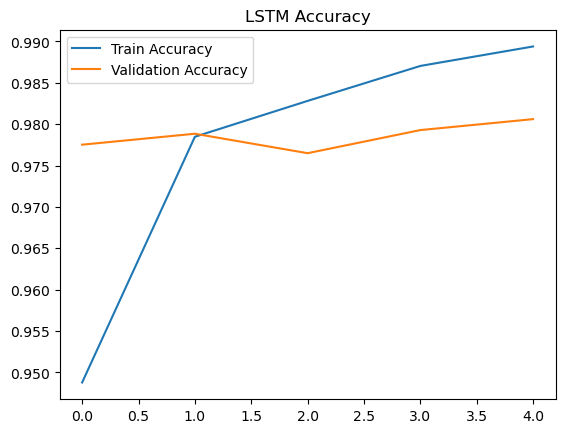

In [38]:
plt.plot(lstm_history.history['accuracy'], label='Train Accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Accuracy')
plt.legend()
plt.show()

In [39]:
print("LSTM Model Evaluation")
lstm_predictions = (lstm_model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, lstm_predictions))
print("LSTM F1 Score:", f1_score(y_test, lstm_predictions))

LSTM Model Evaluation
213/213 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3396
           1       0.98      0.98      0.98      3410

    accuracy                           0.98      6806
   macro avg       0.98      0.98      0.98      6806
weighted avg       0.98      0.98      0.98      6806

LSTM F1 Score: 0.9805825242718447


In [40]:
lstm_model.save("fake_job_lstm_model.h5")

In [41]:
import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
